# Establish quantum phase estimation

In [1]:
#initial
import matplotlib.pyplot as plt
import numpy as np
import math
import json
#  Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram

import itertools

In [2]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

qc = QuantumCircuit(4, 3)
qc.x(3)
for i in range(3):
    qc.h(i)
repetitions=1
for j in range(3):
    for i in range(repetitions):
        qc.cp(math.pi/4, j, 3); 
    repetitions *= 2
qc.barrier()



qft_dagger(qc, 3)

qc.barrier()
for n in range(3):
    qc.measure(n,n)


/Users/yuchao/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


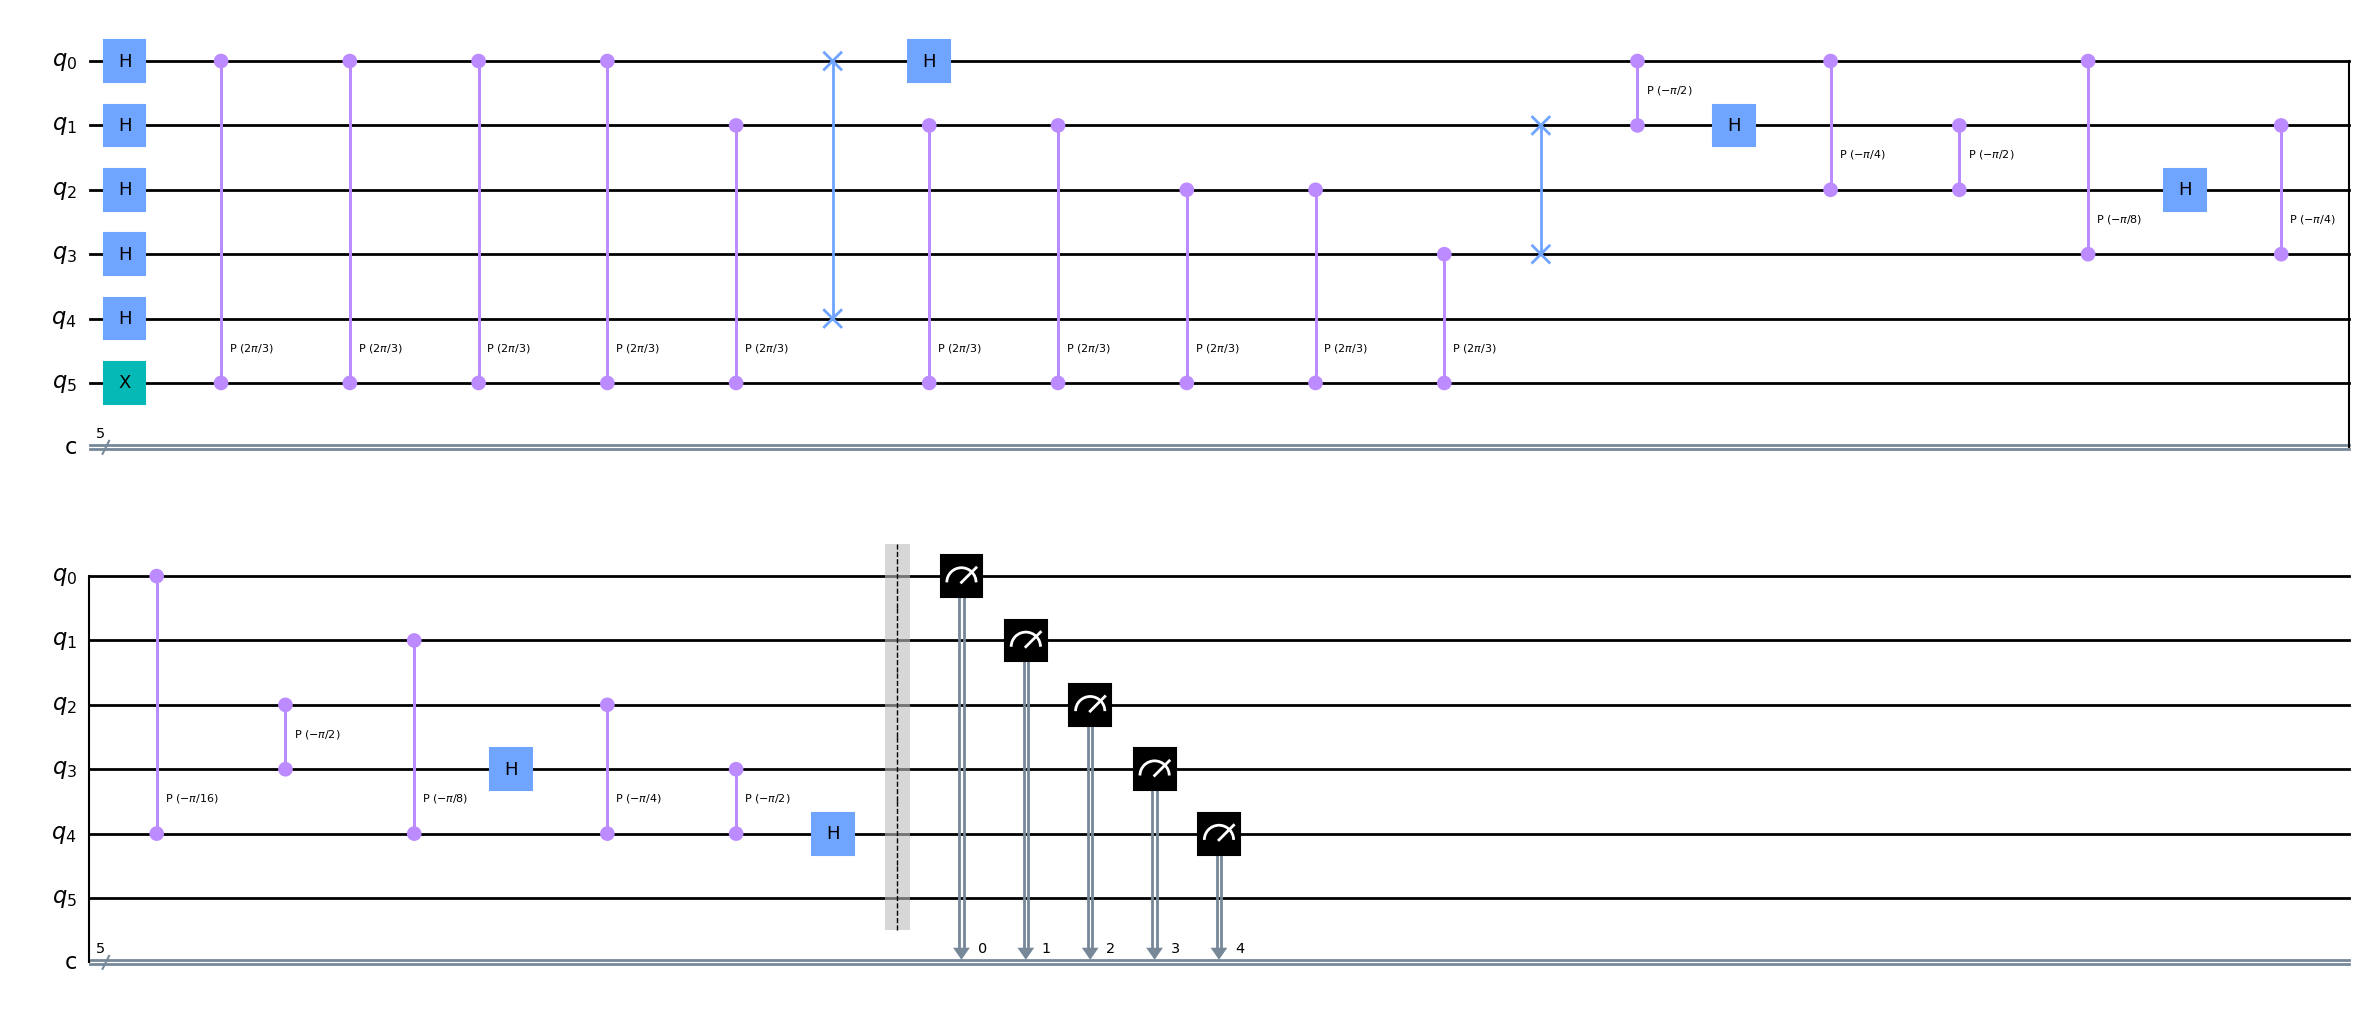

In [3]:
#build QuantumCircuit
qc  = QuantumCircuit(6, 5)


for i in range(5):
    qc.h(i)


qc.x(5)


angle = 2*math.pi/3

for j in range(5):
    for i in range(i):
        qc.cp(angle, j, 5);
    repetitions *= 2


qft_dagger(qc, 5)


qc.barrier()
for i in range(5):
    qc.measure(i,i)

qc.draw('mpl', fold = 35)

In [4]:

aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
trans_qc = transpile(qc, aer_sim)
qobj = assemble(trans_qc, shots=shots)
results = aer_sim.run(qobj).result()
qpe_result = results.get_counts()

print(qpe_result)

{'11100': 6, '01010': 26, '00110': 299, '10110': 85, '00000': 57, '00010': 65, '10000': 207, '01100': 407, '00100': 255, '10100': 134, '10010': 109, '11110': 274, '01110': 2172}


/var/folders/kh/vvf0y3ls11586918v2761md40000gn/T/ipykernel_23418/569759391.py:6: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = aer_sim.run(qobj).result()


In [5]:

# should construct a vector with length 2**N 
# such that the element start from 0 to 2**N - 1

count_ = results.get_counts()
probs  = {}
space  = " ".ljust(5, "0")

for output in [format(i, '0'+str(5)+'b') for i in range(2**5)]:
    if output in count_:
        probs[output] = count_[output]/shots
    else:
        probs[output] = 0

prob = [p for basis, p in probs.items()]

print(prob)
print(len(prob))
prob_ground_truth = prob
print(prob_ground_truth)

[0.013916015625, 0, 0.015869140625, 0, 0.062255859375, 0, 0.072998046875, 0, 0, 0, 0.00634765625, 0, 0.099365234375, 0, 0.5302734375, 0, 0.050537109375, 0, 0.026611328125, 0, 0.03271484375, 0, 0.020751953125, 0, 0, 0, 0, 0, 0.00146484375, 0, 0.06689453125, 0]
32
[0.013916015625, 0, 0.015869140625, 0, 0.062255859375, 0, 0.072998046875, 0, 0, 0, 0.00634765625, 0, 0.099365234375, 0, 0.5302734375, 0, 0.050537109375, 0, 0.026611328125, 0, 0.03271484375, 0, 0.020751953125, 0, 0, 0, 0, 0, 0.00146484375, 0, 0.06689453125, 0]


# Biuld Parametrized Quantum Circuit (VQC)

In [6]:


def vqc_layer_ansatz(
    qubits,
    circ,
    parameters,
    layers = 2,
    entangler = "full" # "full" or "linear"
    ):

    for layer in range(layers):

        for d in range (0, len(qubits)):
            circ.rx(parameters[layer][d], qubits[d])
            circ.ry(parameters[layer][d], qubits[d])
            circ.rz(parameters[layer][d+len(qubits)], qubits[d])
        
        #circ.barrier()
        if entangler == "full":
            for i, j in itertools.combinations(qubits, 2):
                circ.cx(qubits[i], qubits[j])

        circ.barrier()

    for d in range (0, len(qubits)):
        circ.rx(parameters[layer][d], qubits[d])

    #circ.measure_all()
    #circ.measure()
    for n in range(len(qubits)-1):
        circ.measure(n, n)

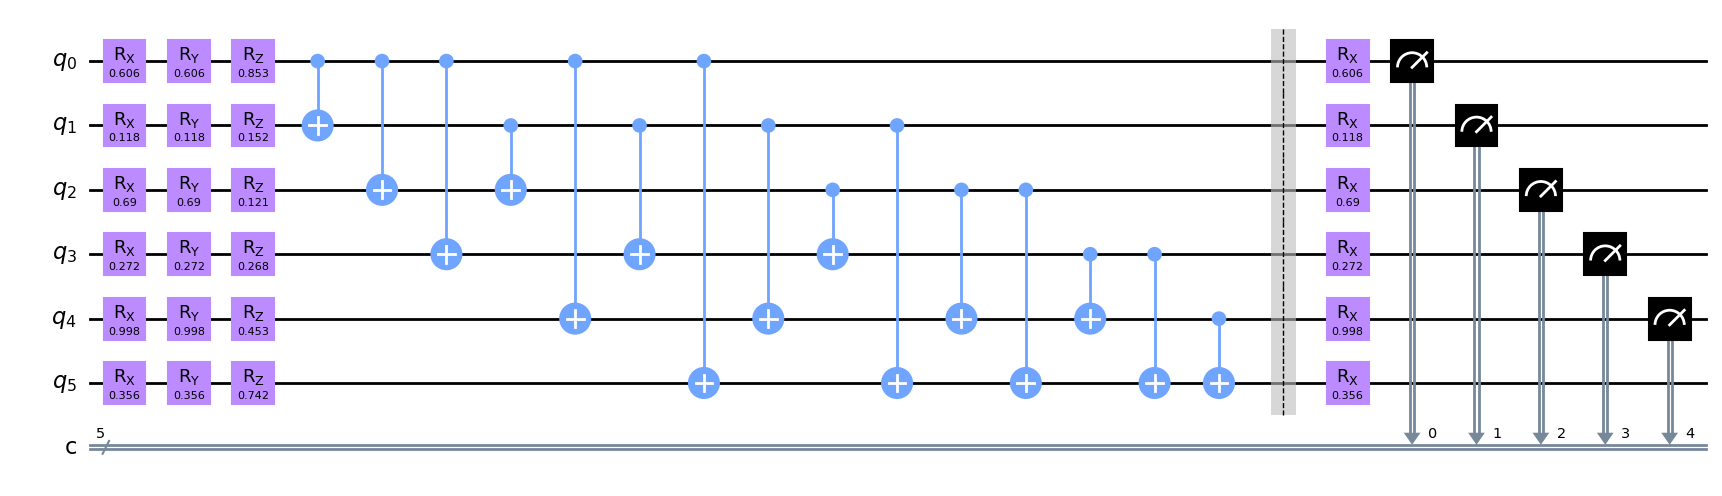

In [7]:
n_qubit = 6
layers  = 1
circ = QuantumCircuit(n_qubit,n_qubit-1)
vqc_layer_ansatz(qubits = list(range(n_qubit)),
                 circ = circ,
                 parameters = np.random.rand(layers+1, n_qubit*2),
                 layers = layers,
                 entangler = "full")
circ.draw(output='mpl', fold = 30)


In [8]:
print("Circuit depth of circ = ", circ.depth())

Circuit depth of circ =  14


In [9]:
from scipy.optimize import minimize, basinhopping

aer_sim = Aer.get_backend('aer_simulator')
def QQPE(
    prob_ground_truth, 
    n_qubit = 6, # count the qubit number
    print_eval_num = True,
    backend = aer_sim,
    shots = 4096,
    layers = 1
    ):

    # Implements the entire cost function on the quantum circuit

    global eval_num
    global backend_
    global shots_
    global prob_gt

    prob_gt  = prob_ground_truth
    shots_   = shots
    backend_ = backend
    eval_num = 0

    def prob_optimize(x):
        """
        Input  : Amplitude of subgroups 
        Output : Corresponding energy of full system 
        """
        global prob_gt

        x = np.array(x)
        prob_gt = np.array(prob_gt)

        err = x - prob_gt
        mse = np.sum(np.sqrt(np.power(err, 2)))

        return mse

    def calculate_cost_function(parameters):
        
        global eval_num
        global backend_
        global shots_ 

        parameters = np.reshape(parameters, (layers+1,n_qubit*2))

        circ = QuantumCircuit(
            QuantumRegister(n_qubit),
            ClassicalRegister(n_qubit-1)
            )

        backend = backend_

        vqc_layer_ansatz(
            qubits     = list(range(n_qubit)),
            circ       = circ, 
            parameters = parameters,
            layers     = layers_,
            entangler  = "full"
            )
        
        t_circ = transpile(circ, backend)
        job = backend.run(t_circ, shots = shots_) 

        eval_num += 1
    
        result = job.result()
        count_ = result.get_counts()
        probs  = {}

        for output in [format(i, '0'+str(n_qubit-1)+'b') for i in range(2**(n_qubit-1))]:

            if output in count_:
                probs[output] = count_[output]/shots_
            else:
                probs[output] = 0
        
        prob = [p for basis, p in probs.items()]

        prob_optimize_result = prob_optimize(prob)
        cost_value = prob_optimize_result
        cost_list.append(cost_value)
        
        if print_eval_num == True:
            print("eval", eval_num, ", cost = ", cost_value)

        return cost_value

    cost_list = []
    layers_ = layers

    print("n_qubit = ",n_qubit)
    out = minimize(calculate_cost_function, x0=np.random.rand((layers_+1) * (n_qubit*2)), method="COBYLA", options={'maxiter':500},
                callback = None) 

    return out.x, cost_list

In [10]:
res_x, cost_list = QQPE(prob_ground_truth)

n_qubit =  6
eval 1 , cost =  1.8388671875
eval 2 , cost =  1.759765625
eval 3 , cost =  1.45849609375
eval 4 , cost =  1.42578125
eval 5 , cost =  1.39990234375
eval 6 , cost =  1.396484375
eval 7 , cost =  1.40087890625
eval 8 , cost =  1.3544921875
eval 9 , cost =  1.40185546875
eval 10 , cost =  1.37841796875
eval 11 , cost =  1.34765625
eval 12 , cost =  1.28271484375
eval 13 , cost =  1.27880859375
eval 14 , cost =  1.2607421875
eval 15 , cost =  1.27490234375
eval 16 , cost =  1.2607421875
eval 17 , cost =  1.291015625
eval 18 , cost =  1.298828125
eval 19 , cost =  1.27734375
eval 20 , cost =  1.2822265625
eval 21 , cost =  1.2822265625
eval 22 , cost =  1.29150390625
eval 23 , cost =  1.24560546875
eval 24 , cost =  1.275390625
eval 25 , cost =  1.25146484375
eval 26 , cost =  1.2802734375
eval 27 , cost =  1.34521484375
eval 28 , cost =  1.1513671875
eval 29 , cost =  1.140625
eval 30 , cost =  1.189453125
eval 31 , cost =  1.27587890625
eval 32 , cost =  1.10888671875
eval 3

### Improved VQC|

In [11]:
import itertools
n_qubit = 6
trained_parameters = res_x
layers = 1
parameters = np.reshape(trained_parameters, (layers+1,n_qubit*2))

circ = QuantumCircuit(
    QuantumRegister(n_qubit),
    ClassicalRegister(n_qubit-1)
    )


def vqc_layer_ansatz(
    qubits,
    circ,
    parameters,
    layers = 2,
    entangler = "full" # "full" or "linear"
    ):

    for layer in range(layers):

        for d in range (0, len(qubits)):
            circ.rx(parameters[layer][d], qubits[d])
            circ.ry(parameters[layer][d], qubits[d])
            circ.rz(parameters[layer][d+len(qubits)], qubits[d])
        #circ.barrier()
        if entangler == "full":
            for i, j in itertools.combinations(qubits, 2):
                circ.cx(qubits[i], qubits[j])

        circ.barrier()

    for d in range (0, len(qubits)):
        circ.rx(parameters[layer][d], qubits[d])



/Users/yuchao/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


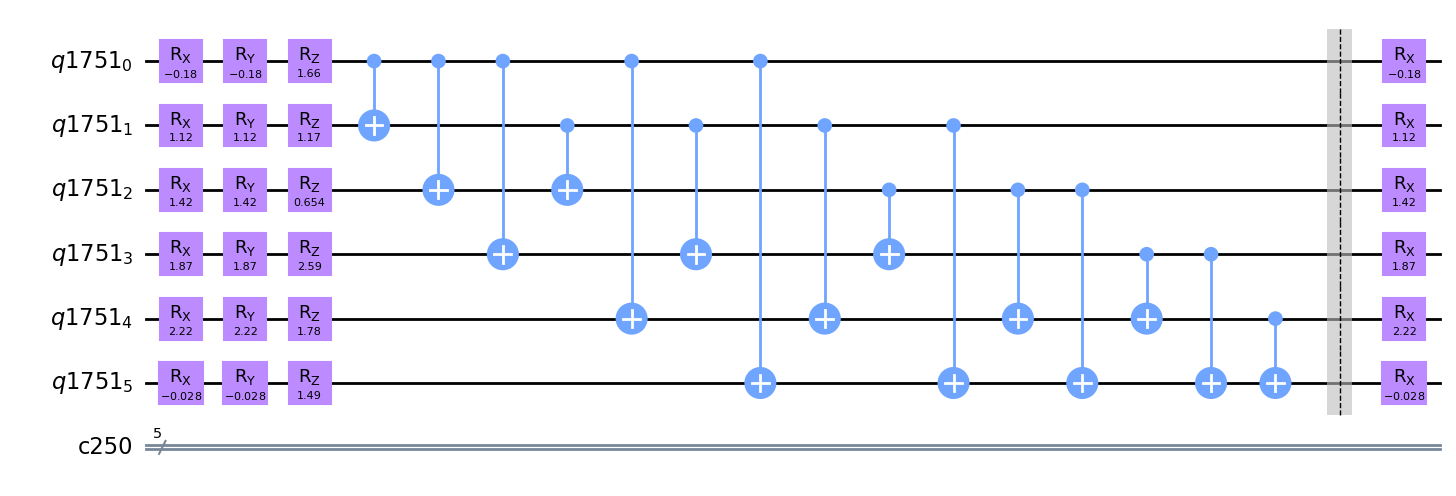

In [12]:
n_qubit = 6
trained_parameters = res_x
layers = 1
parameters = np.reshape(trained_parameters, (layers+1,n_qubit*2))

circ = QuantumCircuit(
    QuantumRegister(n_qubit),
    ClassicalRegister(n_qubit-1)
    )

vqc_layer_ansatz(
    qubits = list(range(n_qubit)),
    circ = circ,
    parameters = parameters,
    layers = layers,
    entangler = "full" # "full" or "linear"
)

circ.draw(output='mpl', fold = 30)



# reverse layer_ansatz

In [13]:
n_qubit = 6
trained_parameters = res_x
layers = 1
parameters = np.reshape(trained_parameters, (layers+1,n_qubit*2))

def reverse_layer_ansatz(qubits, circ, parameters, layers=2, entangler="full"):
   
    for layer in reversed(range(layers)):
        
        for d in reversed(range(len(qubits))):
            circ.rx(-parameters[layer][d], qubits[d])
        
        if entangler == "full":
            for i, j in reversed(list(itertools.combinations(range(len(qubits)), 2))):
                circ.cx(qubits[i], qubits[j])
                

    # Apply the original turnstile in reverse (last layer)
    for d in reversed(range(len(qubits))):
        circ.rz(-parameters[layers][d + len(qubits)], qubits[d])
        circ.ry(-parameters[layers][d], qubits[d])
        circ.rx(-parameters[layers][d], qubits[d])

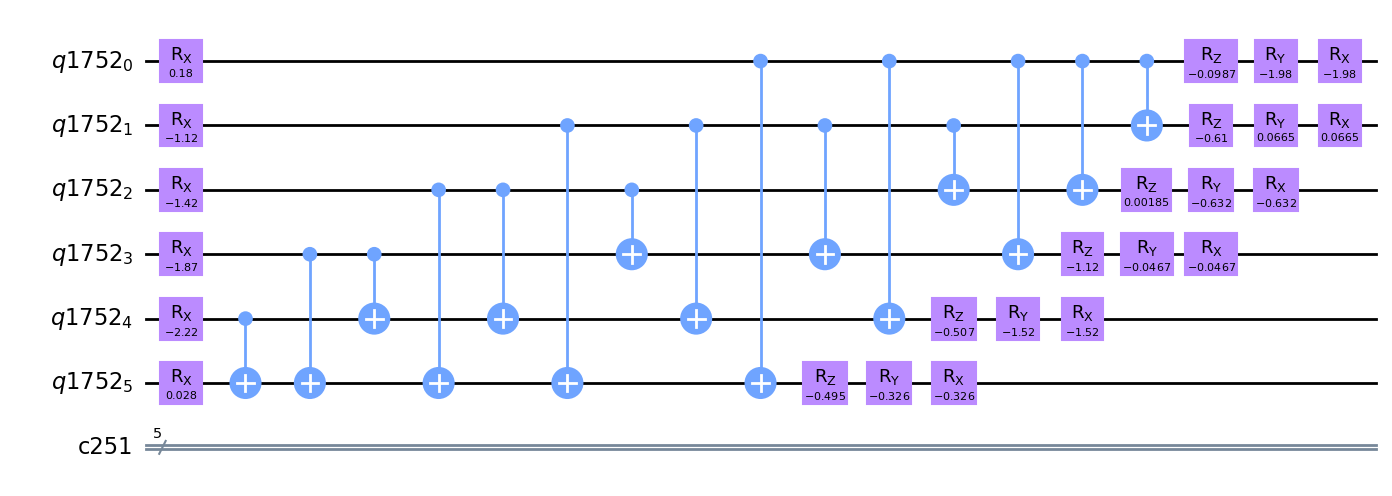

In [14]:
n_qubit = 6
trained_parameters = res_x
layers = 1
parameters = np.reshape(trained_parameters, (layers+1,n_qubit*2))

circ = QuantumCircuit(
    QuantumRegister(n_qubit),
    ClassicalRegister(n_qubit-1)
    )

reverse_layer_ansatz(
    qubits = list(range(n_qubit)),
    circ = circ,
    parameters = parameters,
    layers = layers,
    entangler = "full" 
)

circ.draw(output='mpl', fold = 30)



In [15]:
#Performs a n-controlled Y rotations of angle theta (n can be 1, 2 or 3)
def n_cry(circ, theta, control_qubits, target_qubit, inv = False):
    """Performs a n-controlled Y rotations of angle theta (n can be 1, 2 or 3).
    
    :circ: The circuit in which to perform the controlled rotations
    :theta: The angle of rotation
    :control_qubits: the qubits to be used as control (can be a list or quanutm register) but
                     the size of the register must be 1, 2 or 3
    :target_qubit: The target qubit
    :inv: To be set to True if the target qubit is above the control qubits in the circuit"""
    
    # Convert specified control qubits to a list
    control_list = control_qubits[:]
    size = len(control_list)
    
    
    if size > 6:
        print('Argument n is invalid!')
    else:
            
        if size == 1:
            circ.cry(theta, control_qubits[0], target_qubit)
        else:
           
            new_controls = control_qubits[:-1] if inv else control_qubits[1:]
            
            circ.mct(control_qubits, target_qubit, None, mode='advanced')
            n_cry(circ, -theta/2, new_controls, target_qubit, inv)
            circ.mct(control_qubits, target_qubit, None, mode='advanced')
            n_cry(circ, theta/2, new_controls, target_qubit, inv)

In [17]:
n_qubit = 6

clock_reg = QuantumRegister(5, 'clock')
ancilla_reg = QuantumRegister(1, 'ancilla')
input_reg = QuantumRegister(1, 'input')
measurement_reg = ClassicalRegister(n_qubit-1, 'measurement')
circuit = QuantumCircuit( clock_reg, input_reg,ancilla_reg, measurement_reg)

In [18]:
def hhl(circ,  clock_reg, ancilla_reg, input_reg, measurement_reg):
    """Create the HHL circuit for our specific problem.
    
    :circ: The circuit in which the QPE is performed
    :ancilla_reg: The quantum register holding the ancilla qubit
    :clock_reg: The quantum register holding the eigenvalues
    :input_reg: The quantum register holding the input (what we call |b>)
    :measurement_reg: The classical register holding the results of the mesurements"""
    
    
    vqc_layer_ansatz(
    qubits = list(range(n_qubit)),
    circ = circ,
    parameters = parameters,
    layers = layers,
    entangler = "full" # "full" or "linear"
        )
    circuit.barrier()
    circuit.cry(2.89385, clock_reg[1], ancilla_reg[0])
    circuit.cry(1.69612, clock_reg[0], ancilla_reg[0])
    n_cry(circuit, 0.24774, clock_reg[1:], ancilla_reg[0], inv=True)
    n_cry(circuit, -0.40912, clock_reg[::2], ancilla_reg[0], inv=True)
    n_cry(circuit, -3.54277, clock_reg[:2], ancilla_reg[0], inv=True)
    
    circuit.barrier()
    reverse_layer_ansatz(
    qubits = list(range(n_qubit)),
    circ = circ,
    parameters = parameters,
    layers = layers,
    entangler = "full" # "full" or "linear"
    )

    

Argument n is invalid!


/var/folders/kh/vvf0y3ls11586918v2761md40000gn/T/ipykernel_23418/3480397572.py:27: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circ.mct(control_qubits, target_qubit, None, mode='advanced')
/var/folders/kh/vvf0y3ls11586918v2761md40000gn/T/ipykernel_23418/3480397572.py:29: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circ.mct(control_qubits, target_qubit, None, mode='advanced')


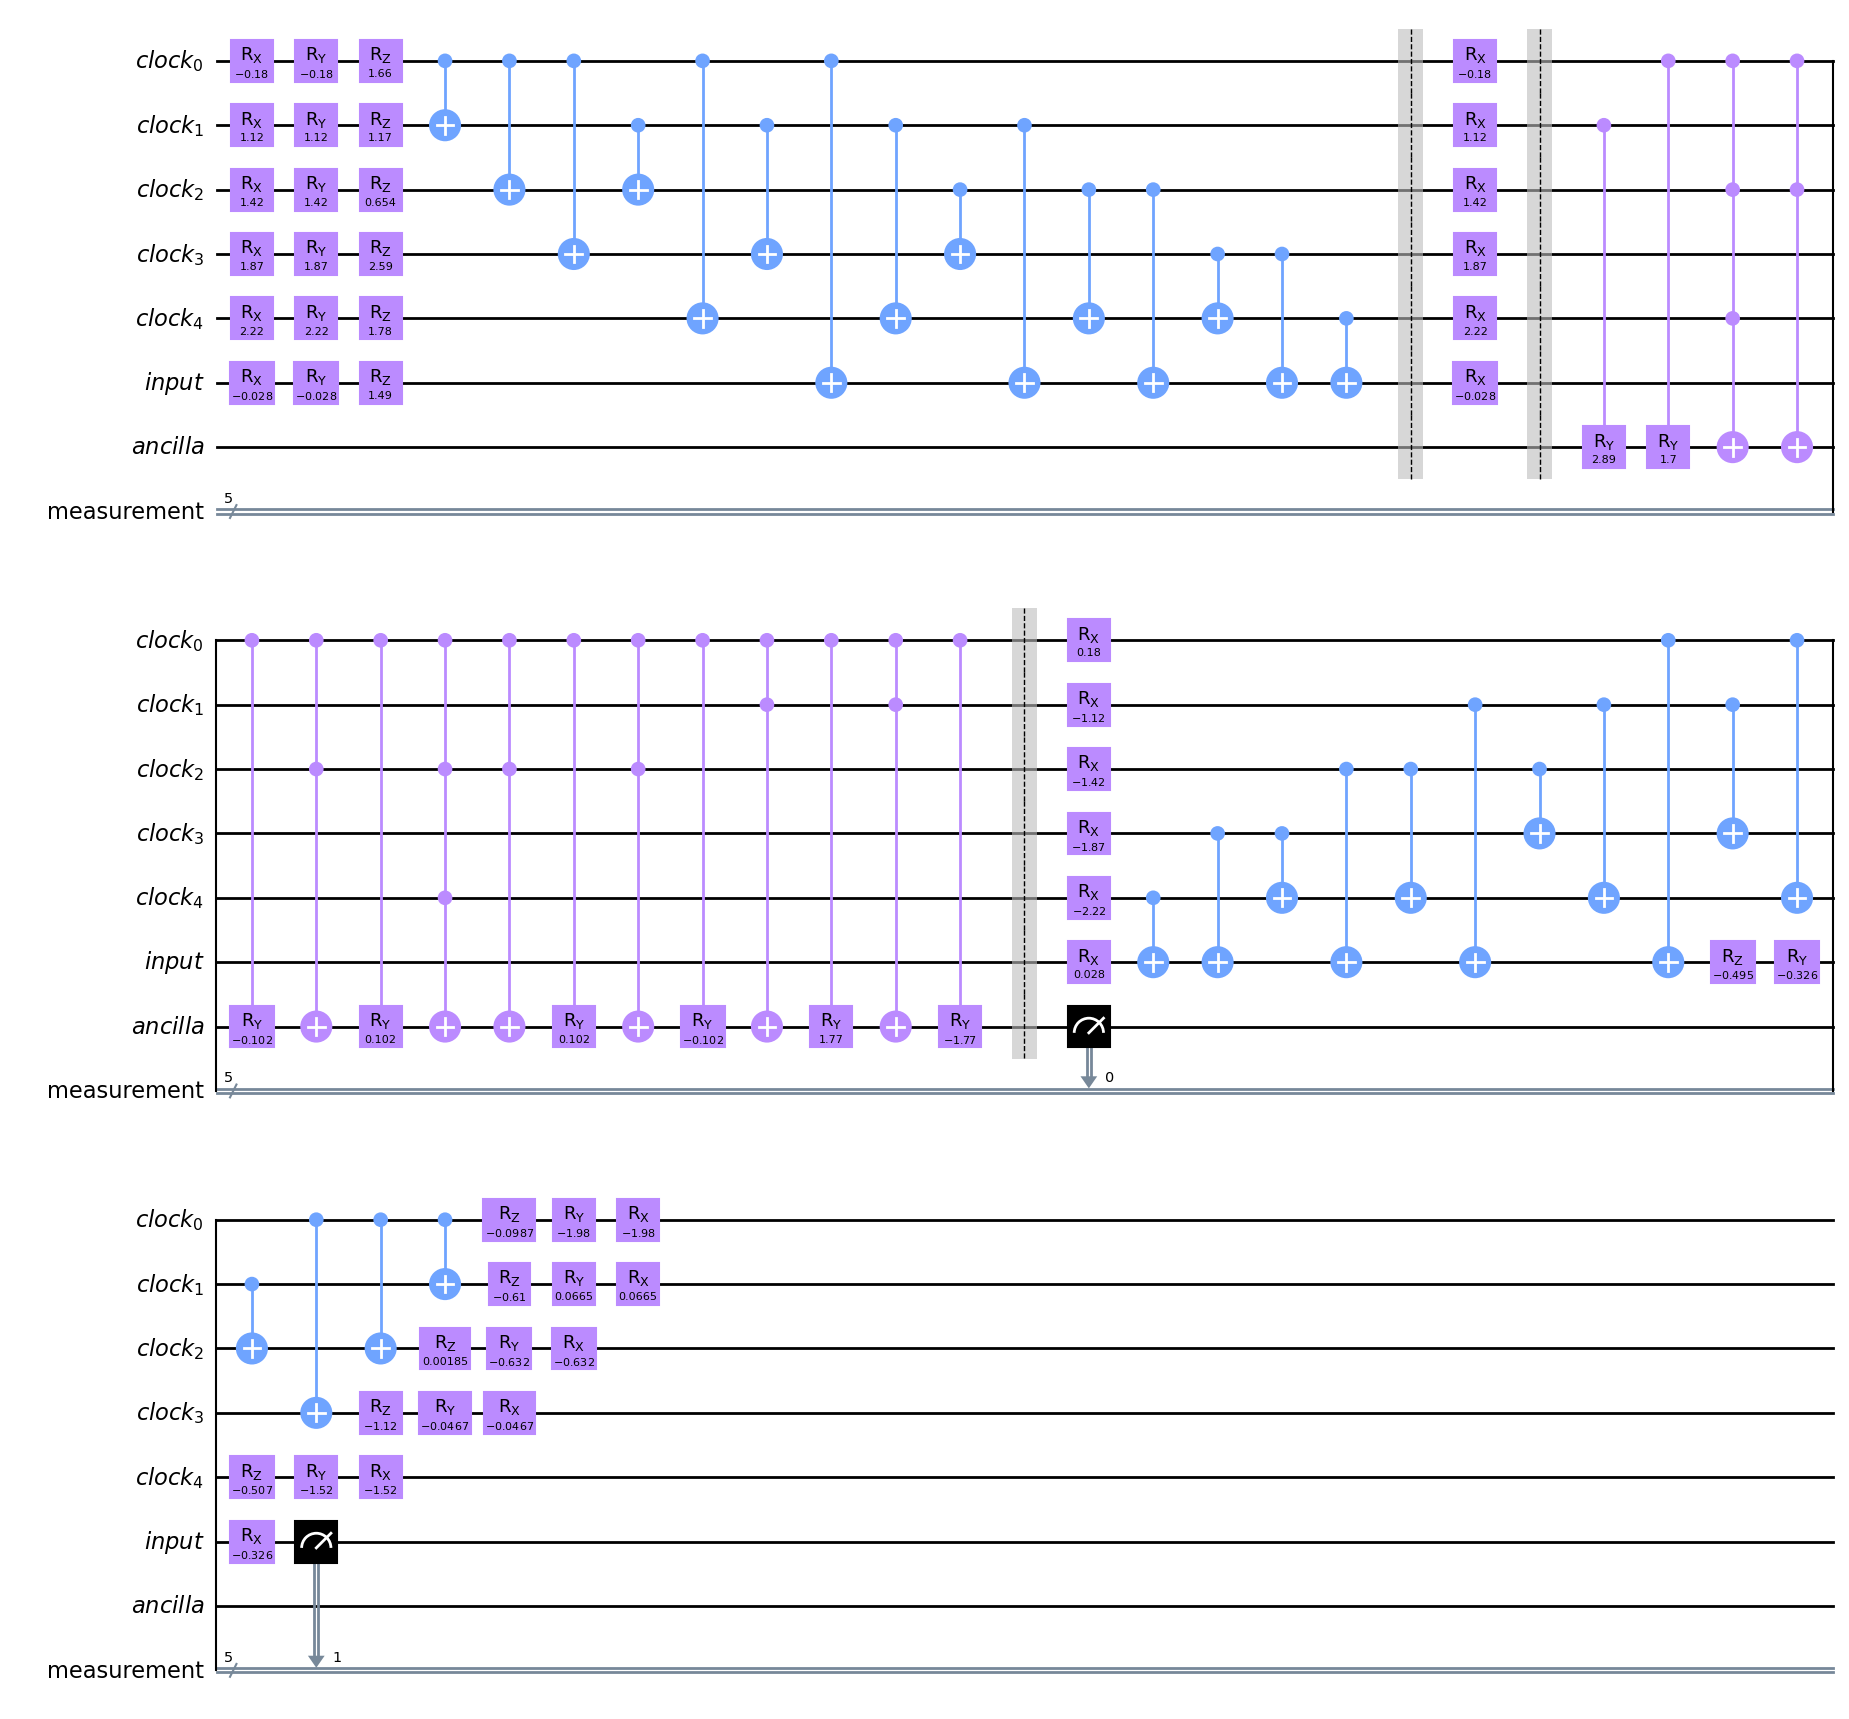

In [19]:
from copy import deepcopy
# Add the HHL circuit to the circuit
hhl(circuit, clock_reg,ancilla_reg, input_reg, measurement_reg)

# Save a version of the circuit with no measurement (useful for getting exact quantum state in simulator)
circuit_no_measure = deepcopy(circuit)

# Add measurements to the original circuit (for running on quantum computers)
circuit.measure(ancilla_reg, measurement_reg[0])
circuit.measure(input_reg, measurement_reg[1])
# Add measurements to the original circuit (for running on quantum computers)
circuit.draw("mpl")

{'00000': 25592, '00011': 12660, '00010': 10746, '00001': 16538}


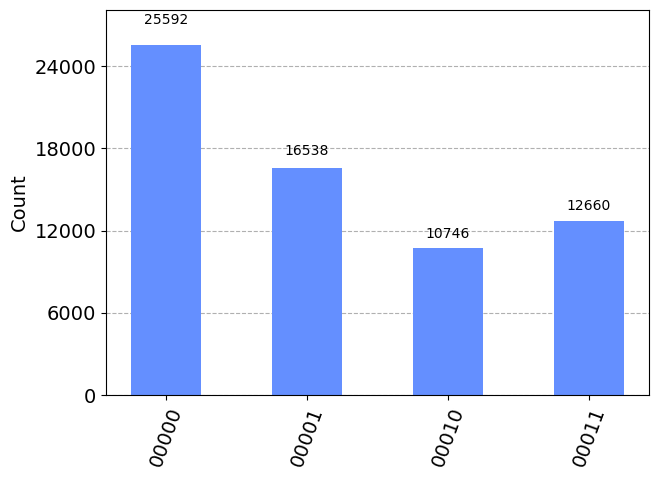

In [23]:
import qiskit
from qiskit import execute
# Use  QASM simulator
simulator = qiskit.BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
count = result.get_counts(circuit)

print(count)
plot_histogram(count)

In [24]:
print("Circuit depth of circ = ", circuit.depth())

Circuit depth of circ =  42


In [25]:
from qiskit import*

In [26]:
from qiskit.tools.jupyter import *
apitoken = 'my-token'
try :
    IBMQ.enable_account(token=apitoken)
except:
    pass

/var/folders/kh/vvf0y3ls11586918v2761md40000gn/T/ipykernel_23418/3230394926.py:4: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.enable_account(token=apitoken)


In [27]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [28]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_brisbane')

In [ ]:
from qiskit.visualization import plot_histogram
%matplotlib inline
backend = provider.get_backend('ibm_brisbane')

job = execute(circuit, backend=backend, shots=2048)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
count = result.get_counts(circuit)

print(count)
display(plot_histogram(job.result().get_counts(), color='midnightblue'))